# Vehicle sales & revenue imputation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
pd.options.mode.chained_assignment = None #disabling useless warnings
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mticker
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import pearsonr

In [2]:
# importing data from csv file
data = pd.read_csv("data_in_csv.zip", sep=';', header=0, compression='zip')
data = data[['sellingprice','saledate']] # Only the number of sales and revenue will be imputed
print(data.head())
print()
print(data.info())

   sellingprice                                 saledate
0             1  Thu Feb 12 2015 03:00:00 GMT-0800 (PST)
1             1  Tue Jan 06 2015 09:30:00 GMT-0800 (PST)
2           100  Fri May 22 2015 02:00:00 GMT-0700 (PDT)
3           100  Thu Apr 02 2015 05:02:00 GMT-0700 (PDT)
4           100  Thu May 14 2015 03:00:00 GMT-0700 (PDT)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432602 entries, 0 to 432601
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   sellingprice  432602 non-null  int64 
 1   saledate      432602 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.6+ MB
None


In [3]:
# extracting a date from saledate column
data['saledate'] = data['saledate'].str.slice(0,-15) # removing time zone from saledate column
data['datetime'] = pd.to_datetime(data['saledate'], errors='coerce', format='%a %b %d %Y %H:%M:%S')
data['date'] = data['datetime'].dt.date
del data['datetime']
del data['saledate']
print(data.head())

   sellingprice        date
0             1  2015-02-12
1             1  2015-01-06
2           100  2015-05-22
3           100  2015-04-02
4           100  2015-05-14


In [4]:
# selecting only the relevant time period
data = data.sort_values('date', ascending=True)
data = data[np.logical_and(data['date']>=dt.date(2015,1,1), data['date']<=dt.date(2015,6,30))]

In [5]:
# grouping by date
data = data.groupby('date').agg({'sellingprice':['size','sum']})
print(data.head())

           sellingprice          
                   size       sum
date                             
2015-01-01            9    186200
2015-01-02          740  10089050
2015-01-04            6     69800
2015-01-05          700   7951100
2015-01-06         6343  78646519


In [6]:
# fixing multi-index issue
data.columns = data.columns.droplevel(0)

# fixing row indexing
data = data.reset_index() 

# changing column names
data = data.rename(columns={'size':'sales_number', 'sum':'revenue'})
print(data.head())

         date  sales_number   revenue
0  2015-01-01             9    186200
1  2015-01-02           740  10089050
2  2015-01-04             6     69800
3  2015-01-05           700   7951100
4  2015-01-06          6343  78646519


In [7]:
# creating a dataframe with all dates from the relevant range
expanded_data = pd.date_range(start='2015-01-01',end='2015-06-30', freq='D', inclusive='both').to_frame()
expanded_data['date'] = expanded_data.iloc[:,0]
expanded_data = expanded_data.drop(columns=[0], axis=1) #removing the column with no label
print(expanded_data.head())

                 date
2015-01-01 2015-01-01
2015-01-02 2015-01-02
2015-01-03 2015-01-03
2015-01-04 2015-01-04
2015-01-05 2015-01-05


In [8]:
# converting date columns to the same datatype
expanded_data['date'] = pd.to_datetime(expanded_data['date'])
data['date'] = pd.to_datetime(data['date'])

print(data['date'].info())
print()
print(expanded_data['date'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 137 entries, 0 to 136
Series name: date
Non-Null Count  Dtype         
--------------  -----         
137 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 KB
None

<class 'pandas.core.series.Series'>
DatetimeIndex: 181 entries, 2015-01-01 to 2015-06-30
Freq: D
Series name: date
Non-Null Count  Dtype         
--------------  -----         
181 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.8 KB
None


In [9]:
# merging values to the full-range table
full_data = expanded_data.merge(data, how='left', on='date', sort=True)
full_data = full_data.fillna(value=0) # replacing NaN with 0
print(full_data.head())

        date  sales_number     revenue
0 2015-01-01           9.0    186200.0
1 2015-01-02         740.0  10089050.0
2 2015-01-03           0.0         0.0
3 2015-01-04           6.0     69800.0
4 2015-01-05         700.0   7951100.0


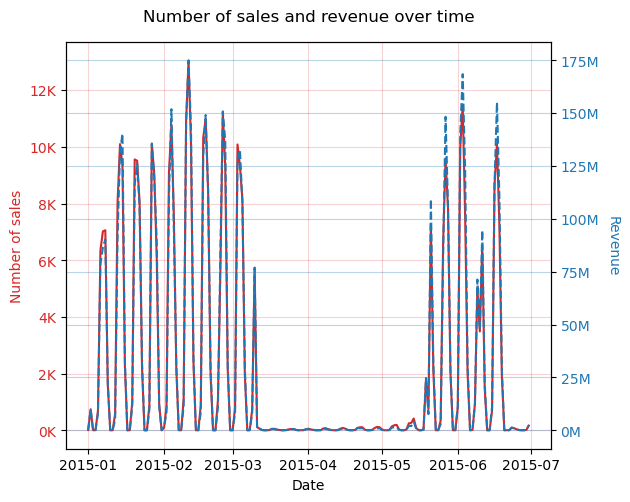

In [10]:
# plotting the data on a line chart
d = full_data['date']
y1 = full_data['sales_number']
y2 = full_data['revenue']

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of sales', color=color)
ax1.plot(d, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(color=color, alpha=0.2)

ax2 = ax1.twinx()  # adds a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color, rotation=270, labelpad=15) 
ax2.plot(d, y2, color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}M'))
plt.grid(color=color, alpha=0.3)

fig.tight_layout()
plt.title('Number of sales and revenue over time', pad=15)
plt.show()

Since revenue is highly dependent on the number of sales, the imputation process will be performed on sales_number solely. Later on, the revenue will be estimated based on the gathered results from the sales number modeling.

In [11]:
# adding a column with integer indexes for linear regression
full_data = full_data.reset_index()

In [12]:
# creating a dataframe which keeps only the proper data that doesn't need to be imputed
cut_data = full_data[np.logical_or(full_data['date']<'2015-03-11', full_data['date']>'2015-05-18')]
print(cut_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 180
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         112 non-null    int64         
 1   date          112 non-null    datetime64[ns]
 2   sales_number  112 non-null    float64       
 3   revenue       112 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.4 KB
None


In [13]:
# splitting data into train and test parts
train_data = cut_data[cut_data['index']<75]
test_data = cut_data[cut_data['index']>125]

In [14]:
# checking whether the (training) time series is stationary (ADF test)
# null hypothesis = time series is non-stationary

def adf_test(series):
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(train_data['sales_number'])

ADF Statistic:  -3.4585078548920625
P-Value:  0.009118876984536473
Critical Values:
	1%: -3.54
	5%: -2.91
	10%: -2.59


The null hypothesis of the Augmented Dickey-Fuller test is rejected as the P-value is smaller than 1%, so it can be said with 99% confidence that the time series is stationary (constant variance and mean through time).
It means that the assumption for autocorrelation test is met.

--- Autocorrelation ---
[ 1.          0.54732704 -0.15884751 -0.71249751 -0.72127766 -0.199787
  0.4674705   0.85876616  0.48556343 -0.15841145 -0.65316591 -0.66348671
 -0.20820363  0.38028271  0.74081181  0.43284228 -0.12398354 -0.56974812
 -0.58534272]


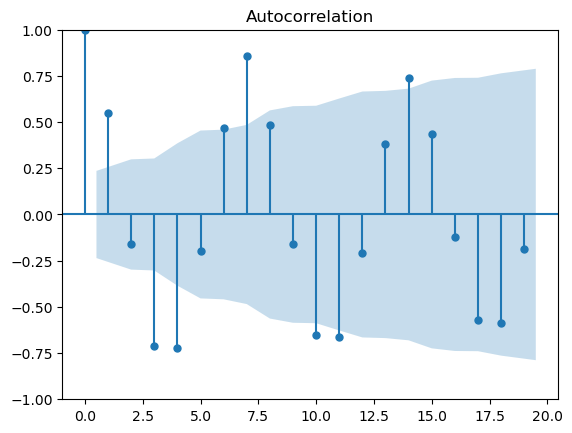

--- Partial Autocorrelation ---
[ 1.          0.55537597 -0.68256315 -0.57649525 -0.26792475  0.09992293
  0.35674143  0.78437534 -0.55836044 -0.81310279 -0.12861342  2.47817171
 -0.28277205  1.95366974  0.73869082 -0.62214496 -0.37073798  0.17750001
  0.50204374]


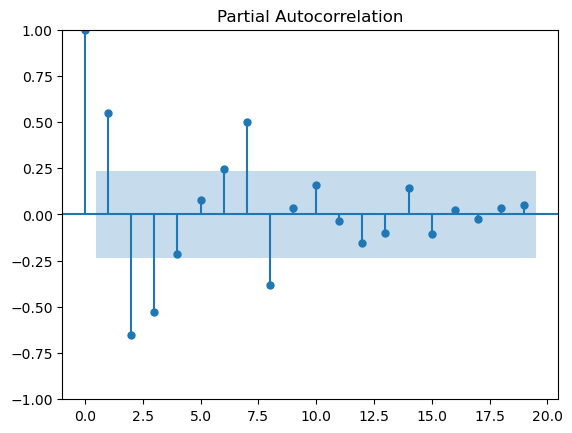

In [15]:
# checking the data for seasonality
# autocorrelation function
print('--- Autocorrelation ---')
acf_result = statsmodels.tsa.stattools.acf(train_data['sales_number'])
print(acf_result)
plot_acf(train_data['sales_number'])
plt.show()

# partial autocorrelation function
print('--- Partial Autocorrelation ---')
pacf_result = statsmodels.tsa.stattools.pacf(train_data['sales_number'])
print(pacf_result)
plot_pacf(train_data['sales_number'])
plt.show()

Autocorrelation chart has a sinusoidal shape, which confirms the occurence of seasonality. Moreover, spikes lagged by 7 and 14 days show that autocorrelations for these periods are positive and statistically significant, which suggests weekly seasonality.

This conclusion is confirmed by partial autocorrelation chart as it also indicates significant positive autocorrelation with values lagged by 7 days.

Additionally, significant negative autocorrelations for 2- and 3-day lags represent lower phase of weekly seasonality cycle.

In this case a suitable modeling technique is seasonality coefficients method, which will be executed in the following steps. As variance of the number of sales remains on a similar level along the whole time series (excluding the period for imputation) the additive approach for seasonality coefficients method would be a better option than the multiplicative one.

In [16]:
# calculating the trend line values for training data
train_x = train_data[['index']]
train_y = train_data[['sales_number']]
train_model = LinearRegression().fit(train_x, train_y)
train_data['sales_number_trend'] = train_model.intercept_ + train_model.coef_ * train_x

print(f"intercept: {train_model.intercept_}")
print(f"slope: {train_model.coef_}")
print(train_data.head())

intercept: [3402.38219462]
slope: [[18.36386555]]
   index       date  sales_number     revenue  sales_number_trend
0      0 2015-01-01           9.0    186200.0         3402.382195
1      1 2015-01-02         740.0  10089050.0         3420.746060
2      2 2015-01-03           0.0         0.0         3439.109926
3      3 2015-01-04           6.0     69800.0         3457.473791
4      4 2015-01-05         700.0   7951100.0         3475.837657


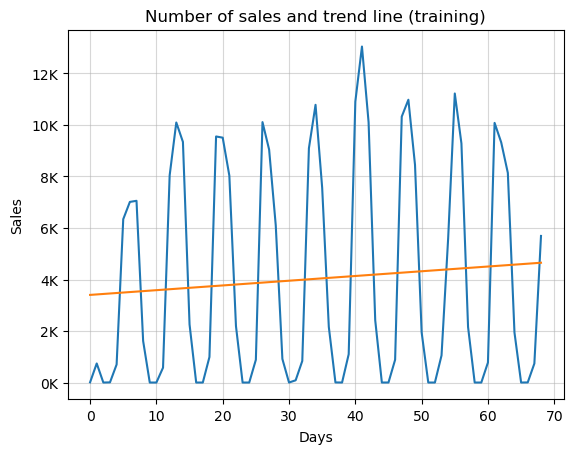

In [17]:
# visualizing trend line for training data
fig, ax = plt.subplots()
plt.plot(train_data['index'], train_data['sales_number'])
plt.plot(train_data['index'], train_data['sales_number_trend'])
plt.title('Number of sales and trend line (training)')
plt.xlabel('Days', labelpad=5) 
plt.ylabel('Sales', labelpad=5) 
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.show()

In [18]:
# calculating residuals from the trend line
train_data['residuals'] = train_data['sales_number']-train_data['sales_number_trend']

# calculating average residuals value for each day of week (raw seasonality coefficients)
train_data['day_index'] = train_data['index']%7+1 # day of the week column
phase_mean = train_data.groupby('day_index').agg({'residuals':'mean'})
phase_mean = phase_mean.reset_index()
print(phase_mean.head(10))

   day_index    residuals
0          1  3427.556041
1          2 -2165.107825
2          3 -4017.171690
3          4 -4026.135556
4          5 -3200.199422
5          6  4503.336713
6          7  6086.357488


In [19]:
# calculating clean seasonality coefficients
cleaner = phase_mean['residuals'].mean()
phase_mean['residuals'] = phase_mean['residuals'] - cleaner

In [20]:
# after cleaning the seasonality coefficients must sum up to zero
print(phase_mean['residuals'].sum())

0.0


In [21]:
# merging average residuals values to the training data
train_data = train_data.merge(phase_mean, on='day_index', how='left')
train_data = train_data.rename(columns={'residuals_x':'residuals','residuals_y':'phase_mean'})
print(train_data[['day_index','phase_mean']].head(10))

   day_index   phase_mean
0          1  3340.608077
1          2 -2252.055789
2          3 -4104.119655
3          4 -4113.083520
4          5 -3287.147386
5          6  4416.388749
6          7  5999.409524
7          1  3340.608077
8          2 -2252.055789
9          3 -4104.119655


In [22]:
# estimating the number of sales
train_data['est_sales_number'] = train_data['sales_number_trend'] + train_data['phase_mean']

# replacing negative estimated values with zero
for lab, row in train_data.iterrows():
    if row['est_sales_number'] < 0:
        train_data.loc[lab, 'est_sales_number'] = 0

Some of the estimated values at indexes from 0 to 35 are negative. The issue is caused by near-to-zero number of sales at lower phase of seaonality cycles and the generally positive linear trend of training data. The negative values don't have substantive justification, so they will be replaced with the smallest possible number of sales = 0. This replacement will not affect the imputation process because the negative values occure up to the 35th day but imputation will concern indexes starting from 70.

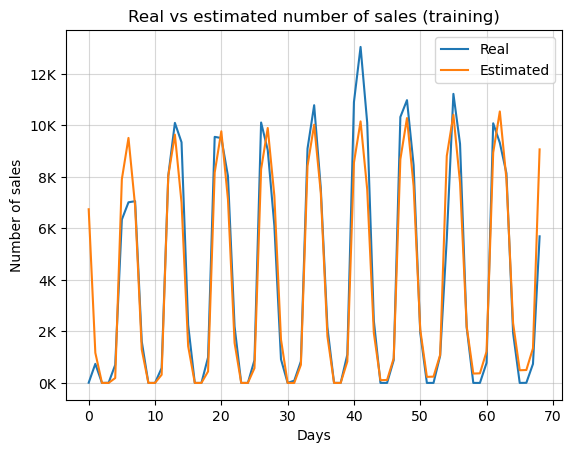

In [23]:
# plotting the estimation results
fig, ax = plt.subplots()
plt.plot(train_data['index'], train_data['sales_number'], label='Real')
plt.plot(train_data['index'], train_data['est_sales_number'], label='Estimated')
plt.title('Real vs estimated number of sales (training)')
plt.xlabel('Days')
plt.ylabel('Number of sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.legend()
plt.show()

The model seems to fit the training data quite well, but it needs to be evaluated based on the fit to the testing data.

In [24]:
# using the testing data to evaluate the model
test_data['sales_number_trend'] = train_model.intercept_ + train_model.coef_ * test_data[['index']]
test_data['day_index'] = test_data['index']%7+1
test_data = test_data.merge(phase_mean, on='day_index', how='left')
test_data = test_data.rename(columns={'residuals':'phase_mean'})
test_data['est_sales_number'] = test_data['sales_number_trend'] + test_data['phase_mean']

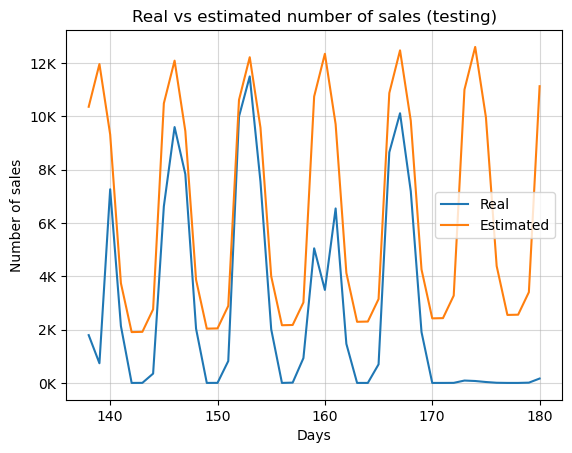

In [25]:
# visualizing the model fit to the testing data
fig, ax = plt.subplots()
plt.plot(test_data['index'], test_data['sales_number'], label='Real')
plt.plot(test_data['index'], test_data['est_sales_number'], label='Estimated')
plt.title('Real vs estimated number of sales (testing)')
plt.xlabel('Days')
plt.ylabel('Number of sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.legend()
plt.show()

It can be easily seen that the model overestimates sales numbers at the later period of the time series. It is caused by the positive trend line calculated on training dataset only. The next iteration of modeling will involve the trend line calculated on the whole dataset.

Besides that, the seasonality has been captured pretty well, so it doesn't require any changes.

intercept: [4318.99328651]
slope: [[-9.72125102]]
   index       date  sales_number     revenue        trend
0      0 2015-01-01           9.0    186200.0  4318.993287
1      1 2015-01-02         740.0  10089050.0  4309.272035
2      2 2015-01-03           0.0         0.0  4299.550784
3      3 2015-01-04           6.0     69800.0  4289.829533
4      4 2015-01-05         700.0   7951100.0  4280.108282


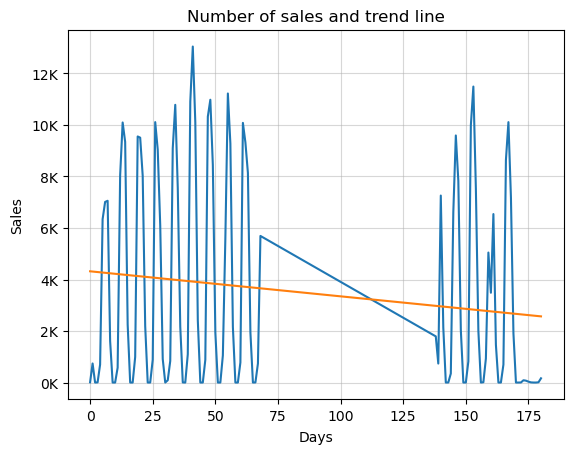

In [26]:
# calculating the trend line values for the whole time series
main_x = cut_data[['index']]
main_y = cut_data[['sales_number']]
main_model = LinearRegression().fit(main_x, main_y)
cut_data['trend'] = main_model.intercept_ + main_model.coef_ * main_x

print(f"intercept: {main_model.intercept_}")
print(f"slope: {main_model.coef_}")
print(cut_data.head())

fig, ax = plt.subplots()
plt.plot(cut_data['index'], cut_data['sales_number'])
plt.plot(cut_data['index'], cut_data['trend'])
plt.title('Number of sales and trend line')
plt.xlabel('Days', labelpad=5) 
plt.ylabel('Sales', labelpad=5) 
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.show()

Switching from the trend line calculated on the training dataset only to the whole dataset signigicantly changes the estimation. The trend line calculated on the whole dataset has negative direction, which is the opposite of trend line from the training dataset. It might improve estimation and avoid overestimation at the later period.

In [27]:
# creating new training and testing datasets
new_train_data = cut_data[cut_data['index']<75]
new_test_data = cut_data[cut_data['index']>125]

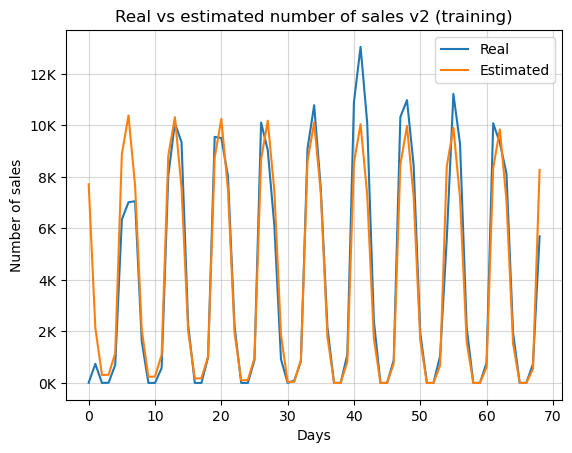

In [28]:
# executing the whole modeling process once again with the new trend line
new_train_data['residuals'] = new_train_data['sales_number'] - new_train_data['trend']

new_train_data['day_index'] = new_train_data['index'] % 7 + 1

new_phase_mean = new_train_data.groupby('day_index').agg({'residuals':'mean'})
new_phase_mean = new_phase_mean.reset_index()

new_train_data = new_train_data.merge(new_phase_mean, on='day_index', how='left')
new_train_data = new_train_data.rename(columns={'residuals_x':'residuals','residuals_y':'phase_mean'})

new_train_data['est_sales_number'] = new_train_data['trend'] + new_train_data['phase_mean']

for lab, row in new_train_data.iterrows():
    if row['est_sales_number'] < 0:
        new_train_data.loc[lab, 'est_sales_number'] = 0

fig, ax = plt.subplots()
plt.plot(new_train_data['index'], new_train_data['sales_number'], label='Real')
plt.plot(new_train_data['index'], new_train_data['est_sales_number'], label='Estimated')
plt.title('Real vs estimated number of sales v2 (training)')
plt.xlabel('Days')
plt.ylabel('Number of sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.legend()
plt.show()

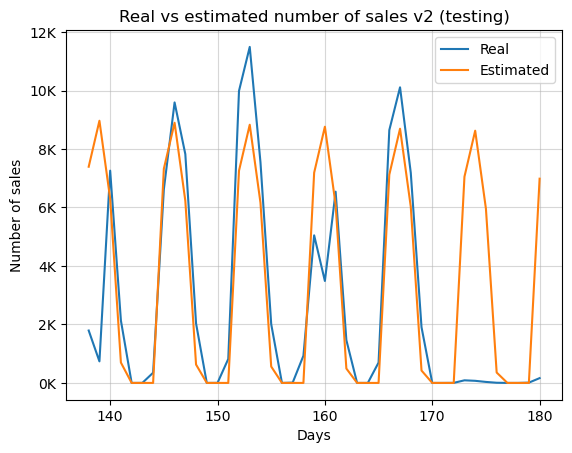

In [29]:
# testing the new model
new_test_data['sales_number_trend'] = main_model.intercept_ + main_model.coef_ * new_test_data[['index']]
new_test_data['day_index'] = new_test_data['index']%7+1
new_test_data = new_test_data.merge(phase_mean, on='day_index', how='left')
new_test_data = new_test_data.rename(columns={'residuals':'phase_mean'})
new_test_data['est_sales_number'] = new_test_data['sales_number_trend'] + new_test_data['phase_mean']

for lab, row in new_test_data.iterrows():
    if row['est_sales_number'] < 0:
        new_test_data.loc[lab, 'est_sales_number'] = 0

fig, ax = plt.subplots()
plt.plot(new_test_data['index'], new_test_data['sales_number'], label='Real')
plt.plot(new_test_data['index'], new_test_data['est_sales_number'], label='Estimated')
plt.title('Real vs estimated number of sales v2 (testing)')
plt.xlabel('Days')
plt.ylabel('Number of sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.legend()
plt.show()

The chart above shows that the new model hasn't had have overestimation issue anymore.

In [30]:
# calculating model evaluation metrics
f_diff = new_test_data['sales_number'] - new_test_data['est_sales_number']
f_diff = f_diff.to_frame()

# MAE
print("MAE", f_diff.abs().mean())

# RMSE
print("RMSE", ((f_diff**2).mean())**0.5)

MAE 0    1737.606486
dtype: float64
RMSE 0    2946.054258
dtype: float64


Mean absolute error indicates that the estimated number of sales differs from the actual number on average by 1738.
On the other hand, root mean square error indicates that the average error in a model's predictions equals 2946.

In a context of sales number range (0 to around 12k) MAE and RMSE are quite moderate as their ratios to the range lenth is around 1/6 and 1/4 correspondingly. The value imputation using this model is acceptable.

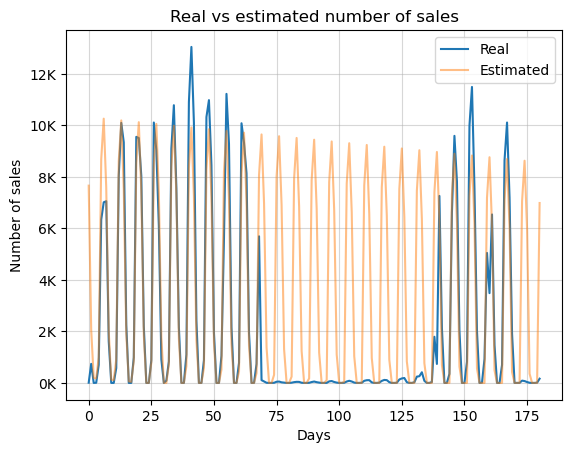

In [31]:
# applying the model to the whole time series
full_data['sales_number_trend'] = main_model.intercept_ + main_model.coef_ * full_data[['index']]
full_data['day_index'] = full_data['index']%7+1
full_data = full_data.merge(phase_mean, on='day_index', how='left')
full_data = full_data.rename(columns={'residuals':'phase_mean'})
full_data['est_sales_number'] = full_data['sales_number_trend'] + full_data['phase_mean']

for lab, row in full_data.iterrows():
    if row['est_sales_number'] < 0:
        full_data.loc[lab, 'est_sales_number'] = 0

# plotting the results
fig, ax = plt.subplots()
plt.plot(full_data['index'], full_data['sales_number'], label='Real')
plt.plot(full_data['index'], full_data['est_sales_number'], label='Estimated', alpha=0.5)
plt.title('Real vs estimated number of sales')
plt.xlabel('Days')
plt.ylabel('Number of sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [32]:
# creating one composite time series
for rlab, row in full_data.iterrows():
    if row['index']<=68:
        full_data.loc[rlab,'imputed_sales'] = row['sales_number']
    elif row['index']<138:
        full_data.loc[rlab,'imputed_sales'] = row['est_sales_number']
    else:
        full_data.loc[rlab,'imputed_sales'] = row['sales_number']

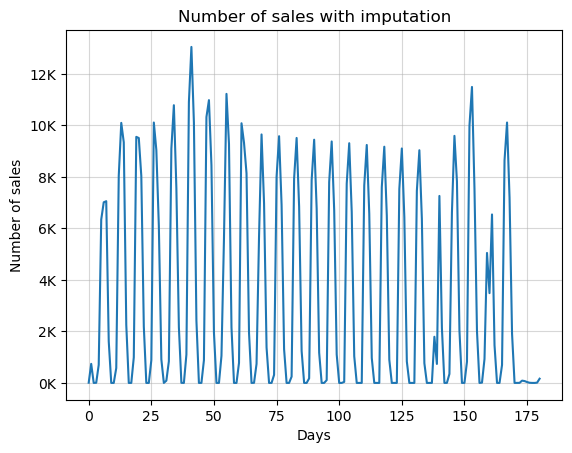

In [33]:
# visualizing the final time series of sales number
fig, ax = plt.subplots()
plt.plot(full_data['index'], full_data['imputed_sales'])
plt.title('Number of sales with imputation')
plt.xlabel('Days')
plt.ylabel('Number of sales')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.grid(alpha=0.5)
plt.show()

As a result of sales number imputation the new time series is more trustworthy as it solves probable data collection issues.

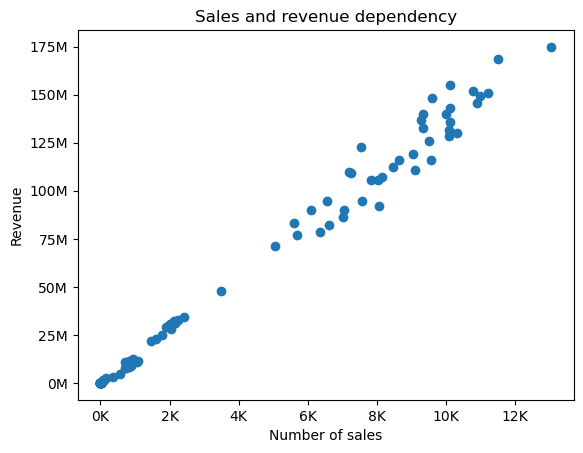

Pearsons correlation: 0.995


In [34]:
# checking the relationship between revenue and sales number
fig, ax = plt.subplots()
plt.scatter(cut_data['sales_number'], cut_data['revenue'])
plt.title('Sales and revenue dependency')
plt.xlabel('Number of sales')
plt.ylabel('Revenue')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}M'))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-3:.0f}K'))
plt.show()

corr, _ = pearsonr(cut_data['sales_number'], cut_data['revenue'])
print('Pearsons correlation: %.3f' % corr)

There is a very strong linear correlation between number of sales and revenue (r=0.995), so the revenue can be easily estimated using number of sales.

In [35]:
# revenue estimation
rev_x = cut_data[['sales_number']]
rev_y = cut_data[['revenue']]
rev_model = LinearRegression().fit(rev_x, rev_y)

full_data['est_revenue'] = rev_model.intercept_ + rev_model.coef_ * full_data[['imputed_sales']]

for rlab, row in full_data.iterrows():
    if row['index']<=68:
        full_data.loc[rlab,'imputed_rev'] = row['revenue']
    elif row['index']<138:
        full_data.loc[rlab,'imputed_rev'] = row['est_revenue']
    else:
        full_data.loc[rlab,'imputed_rev'] = row['revenue']

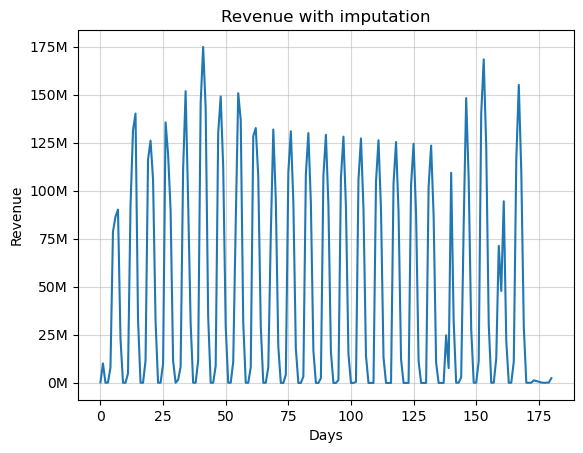

In [36]:
# visualizing the final revenue time series
fig, ax = plt.subplots()
plt.plot(full_data['index'], full_data['imputed_rev'])
plt.title('Revenue with imputation')
plt.xlabel('Days')
plt.ylabel('Revenue')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x*1e-6:.0f}M'))
plt.grid(alpha=0.5)
plt.show()

In [37]:
# exporting the results into .csv file
full_data = full_data[['index','date','imputed_sales','imputed_rev']]
#full_data.to_csv('your_path/imputed_sales_and_revenue.csv')